In [180]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions

#### Read dataset

In [181]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [182]:
EVdata.set_index('StartDate', inplace=True)

In [183]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["Energy (kWh)"]]

In [184]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [185]:
testData["item_id"] = "HAMILTON 1"

In [186]:
testData.head()

,target,item_id
StartDate,,
2011-07-29,6.249457,HAMILTON 1
2011-07-30,28.978653,HAMILTON 1
2011-07-31,37.209163,HAMILTON 1
2011-08-01,5.041244,HAMILTON 1
2011-08-02,4.197217,HAMILTON 1


In [187]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = "D")

#### Handle missing data

In [188]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0

ds = PandasDataset(dfs_dict, target="target")



In [189]:
next(iter(ds))

{'start': Period('2011-07-29', 'D'),
 'target': array([ 6.249457, 28.978653, 37.209163, ..., 44.383   ,  0.      ,
         6.545   ]),
 'item_id': 'HAMILTON 1'}

#### Use train and test split

In [190]:
prediction_length = 500
freq = "1D"
start = pd.Period('2011-07-29', freq = freq)

In [191]:
next(iter(ds))

{'start': Period('2011-07-29', 'D'),
 'target': array([ 6.249457, 28.978653, 37.209163, ..., 44.383   ,  0.      ,
         6.545   ]),
 'item_id': 'HAMILTON 1'}

In [192]:
custom_dataset = next(iter(ds))["target"]

In [193]:
custom_dataset.shape

(3386,)

In [194]:
custom_dataset = custom_dataset.reshape(1, len(custom_dataset))

In [195]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

#### Visualize the dataset

In [196]:
from gluonts.dataset.common import ListDataset

In [197]:
entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series

2011-07-29     6.249457
2011-07-30    28.978653
2011-07-31    37.209164
2011-08-01     5.041244
2011-08-02     4.197217
                ...    
2019-06-18    40.965000
2019-06-19    42.328999
2019-06-20    24.684000
2019-06-21    19.295000
2019-06-22    16.339001
Freq: D, Length: 2886, dtype: float32

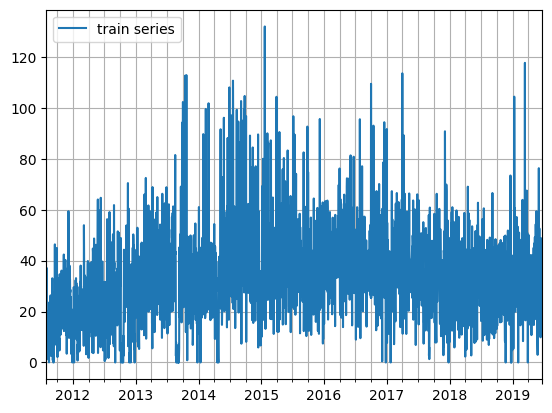

In [198]:
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

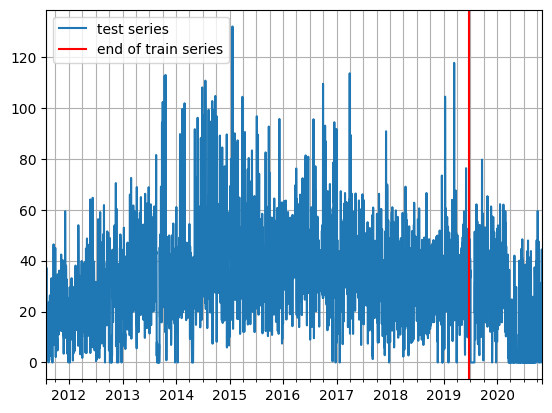

In [199]:
entry = next(iter(test_ds))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [200]:
print(
    f"Length of forecasting window in test dataset: {prediction_length}"
)
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 500
Recommended prediction horizon: 500
Frequency of the time series: 1D


#### Train and prediction

##### DeepARE

In [255]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=100, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [238]:
deepAR_estimator = DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=Trainer(epochs=1)
)

In [239]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

def train_and_predict(train_dataset, test_dataset, estimator):
    predictor = estimator.train(train_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return forecast_it, ts_it


In [256]:
from gluonts.dataset.pandas import PandasDataset

forecast_it, ts_it = train_and_predict(train_ds, test_ds, simple_feed_forward_estimator)

100%|██████████| 100/100 [00:01<00:00, 78.83it/s, epoch=100/100, avg_epoch_loss=4.22]


In [257]:
forecast = list(forecast_it)
tss = list(ts_it)

In [258]:
forecast_entry = forecast[0]
ts_entry = tss[0]

In [259]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 500)
Start date of the forecast window: 2019-06-23
Frequency of the time series: <Day>


In [260]:
print(ts_entry)

                    0
2011-07-29   6.249457
2011-07-30  28.978653
2011-07-31  37.209164
2011-08-01   5.041244
2011-08-02   4.197217
...               ...
2020-10-30  25.440001
2020-10-31  15.122000
2020-11-01  44.382999
2020-11-02   0.000000
2020-11-03   6.545000

[3386 rows x 1 columns]


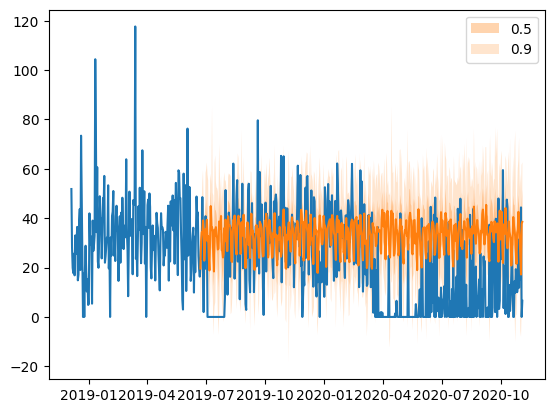

In [261]:
plt.plot(ts_entry[-700:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [262]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecast)

Running evaluation: 1it [00:00,  3.27it/s]


In [263]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 523.5921875,
    "abs_error": 9559.697265625,
    "abs_target_sum": 10153.2109375,
    "abs_target_mean": 20.306421875,
    "seasonal_error": 15.414398288561525,
    "MASE": 1.240359446624512,
    "MAPE": 1.8735239039586242,
    "sMAPE": 0.9390330810546875,
    "MSIS": 10.041901870075852,
    "QuantileLoss[0.1]": 6810.862626285851,
    "Coverage[0.1]": 0.466,
    "QuantileLoss[0.5]": 9559.697758674622,
    "Coverage[0.5]": 0.686,
    "QuantileLoss[0.9]": 3380.049369049071,
    "Coverage[0.9]": 0.92,
    "RMSE": 22.882136864812257,
    "NRMSE": 1.1268423854122382,
    "ND": 0.9415442390069029,
    "wQuantileLoss[0.1]": 0.6708087390492916,
    "wQuantileLoss[0.5]": 0.941544287567858,
    "wQuantileLoss[0.9]": 0.3329044762150221,
    "mean_absolute_QuantileLoss": 6583.536584669848,
    "mean_wQuantileLoss": 0.6484191676107239,
    "MAE_Coverage": 0.4200000000000001,
    "OWA": NaN
}


In [264]:
agg_metrics["MSE"]

523.5921875

In [253]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2019-06-23,504.749875,9445.902344,10153.210938,20.306422,15.414398,1.225595,1.809859,0.944878,0.930336,8.950344,6708.596446,0.472,9445.902987,0.69,3318.264022,0.91


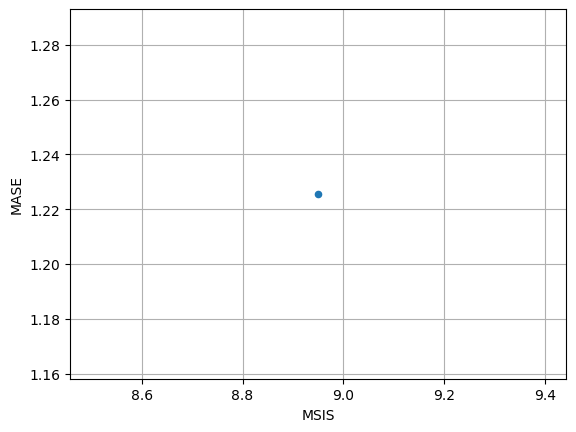

In [254]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()